In [95]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "./image/train"
categories = ['laliga', 'bundesliga', 'kleague', 'ligue1', 'seriea', 'playing']
nb_classes = len(categories)

image_w = 220
image_h = 200

pixels = image_h * image_w * 3

X = []
y = []


for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./numpy_data/multi_image_data.npy", xy)

print("ok", len(y))


laliga  파일 길이 :  244
laliga  :  ./image/train/laliga/frames15875.jpg
bundesliga  파일 길이 :  220
bundesliga  :  ./image/train/bundesliga/bundesliga(97).jpg
kleague  파일 길이 :  317
kleague  :  ./image/train/kleague/kleague(229).jpg
ligue1  파일 길이 :  301
ligue1  :  ./image/train/ligue1/OM vs Strasbourg du 26092018 - 1e_re mi-temps.mp4_001621920.jpg
seriea  파일 길이 :  317
seriea  :  ./image/train/seriea/serieA(190).jpg
ok 1399


In [51]:
X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./numpy_data/multi_image_data.npy", xy)

print("ok", len(y))

ok 1399


In [104]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
from keras import models, layers
from keras import optimizers, initializers, regularizers, metrics
from keras import Input
import math
import numpy as np

In [53]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [54]:
X_train, X_test, y_train, y_test = np.load('./numpy_data/multi_image_data.npy', allow_pickle=True)
print(X_test.shape)
print(X_train.shape)
print(X_train.shape[0])

(350, 64, 64, 3)
(1049, 64, 64, 3)
1049


In [105]:
#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

Found 1399 images belonging to 5 classes.
Found 1399 images belonging to 5 classes.


In [114]:
"""
with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)
"""
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
pre_trained_vgg.trainable = True
pre_trained_vgg.summary()

additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4096, activation='relu'))
additional_model.add(layers.Dense(2048, activation='relu'))
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(6, activation='softmax'))

additional_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = './model'
 
 
additional_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [115]:
#데이터셋이 충분하시면 이렇게 하시지 마시고 validation_split=0.2 이렇게 하셔서 테스트 셋으로 나누시길 권장합니다.
history = additional_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Train on 1049 samples, validate on 350 samples
Epoch 1/50
 192/1049 [====>.........................] - ETA: 51s - loss: 10.0992 - acc: 0.2604

KeyboardInterrupt: 

In [59]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

350/350 [==============================] - 0s 752us/step
정확도 : 1.0000


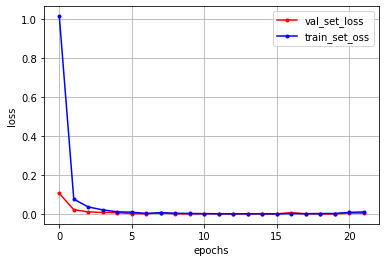

In [120]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
#plt.show()

fig = plt.gcf() #변경한 곳
#plt.show()
fig.savefig('GG.png') #변경한 곳

In [76]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "./image/test"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)
print(filenames)
X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

['./image/test/kleague.png', './image/test/seriea.png', './image/test/ligue1.png', './image/test/laliga.png', './image/test/bundesliga.png']


In [81]:
cnt = 0
#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "라리가"
    elif pre_ans == 1: pre_ans_str = "분데스리가"
    elif pre_ans == 2: pre_ans_str = "K리그"
    elif pre_ans == 3: pre_ans_str = "리그1"
    else: pre_ans_str = "세리에"
        
    print("해당 "+filenames[cnt]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.

[0.000 0.000 0.000 1.000 0.000]
3
해당 ./image/test/kleague.png이미지는 리그1로 추정됩니다.
[0.000 0.000 0.000 0.000 1.000]
4
해당 ./image/test/seriea.png이미지는 세리에로 추정됩니다.
[0.000 0.000 0.000 1.000 0.000]
3
해당 ./image/test/ligue1.png이미지는 리그1로 추정됩니다.
[1.000 0.000 0.000 0.000 0.000]
0
해당 ./image/test/laliga.png이미지는 라리가로 추정됩니다.
[0.000 1.000 0.000 0.000 0.000]
1
해당 ./image/test/bundesliga.png이미지는 분데스리가로 추정됩니다.
